# Pre-process SQuad1 for Sentence Module and BM.

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
!pip install -q tensorflow tensorflow-datasets matplotlib
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf

import tensorflow_datasets as tfds
tfds.disable_progress_bar()
tf.enable_v2_behavior()

In [0]:
import numpy as np
import statistics
from scipy import stats
import tensorflow_datasets as tfds
import pandas as pd
import time
import tensorflow_hub as hub

## Common Functions

In [0]:
#load training json file into PD
import json
def get_pd_data (filepath):
    with open(filepath) as f:
        Squad = json.load(f)
    
    data=pd.DataFrame(columns=['ID','Context','Question','Answers','Start'])
    for article in Squad['data']:
        for paragraph in article['paragraphs']:
            Context=paragraph['context']
            
            for question in paragraph['qas']:
                Question=[]
                Answers=[]
                Start=[]
                ID=[]
                ID.append(str(question['id']))
                Question.append(str(question['question']))
                subA=[]
                subS=[]
                for n,subanswer in enumerate(question['answers']):
                    subA.append(str(question['answers'][n]['text']))
                    subS.append(int(question['answers'][n]['answer_start']))
                Answers=subA
                Start=subS
                temp=pd.DataFrame(data={'ID':[ID],'Context':[Context],'Question':[Question],'Answers':[Answers],'Start':[Start]})
                data=data.append(temp,ignore_index=True)
                               
    return data

In [0]:
data=''
mypath='/gdrive/My Drive/w266/SQuad/data/train-v1.1.json'

In [0]:
with open(mypath) as f:
    Squad = json.load(f)

In [0]:
Squad['data'][0]['paragraphs'][0]['qas']

[{'answers': [{'answer_start': 515, 'text': 'Saint Bernadette Soubirous'}],
  'id': '5733be284776f41900661182',
  'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?'},
 {'answers': [{'answer_start': 188, 'text': 'a copper statue of Christ'}],
  'id': '5733be284776f4190066117f',
  'question': 'What is in front of the Notre Dame Main Building?'},
 {'answers': [{'answer_start': 279, 'text': 'the Main Building'}],
  'id': '5733be284776f41900661180',
  'question': 'The Basilica of the Sacred heart at Notre Dame is beside to which structure?'},
 {'answers': [{'answer_start': 381,
    'text': 'a Marian place of prayer and reflection'}],
  'id': '5733be284776f41900661181',
  'question': 'What is the Grotto at Notre Dame?'},
 {'answers': [{'answer_start': 92,
    'text': 'a golden statue of the Virgin Mary'}],
  'id': '5733be284776f4190066117e',
  'question': 'What sits on top of the Main Building at Notre Dame?'}]

## Pre-process Train data


#### Train v1 dataset

In [0]:
data=get_pd_data(mypath)

In [0]:
data.tail(3)

,ID,Context,Question,Answers,Start
87596,[5735d259012e2f140011a09f],"Kathmandu Metropolitan City (KMC), in order to...",[With what Belorussian city does Kathmandu hav...,[Minsk],[476]
87597,[5735d259012e2f140011a0a0],"Kathmandu Metropolitan City (KMC), in order to...",[In what year did Kathmandu create its initial...,[1975],[199]
87598,[5735d259012e2f140011a0a1],"Kathmandu Metropolitan City (KMC), in order to...",[What is KMC an initialism of?],[Kathmandu Metropolitan City],[0]


In [8]:
!pip install nltk
import nltk.data
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
data.iloc[87596]['Context']

"Kathmandu Metropolitan City (KMC), in order to promote international relations has established an International Relations Secretariat (IRC). KMC's first international relationship was established in 1975 with the city of Eugene, Oregon, United States. This activity has been further enhanced by establishing formal relationships with 8 other cities: Motsumoto City of Japan, Rochester of the USA, Yangon (formerly Rangoon) of Myanmar, Xi'an of the People's Republic of China, Minsk of Belarus, and Pyongyang of the Democratic Republic of Korea. KMC's constant endeavor is to enhance its interaction with SAARC countries, other International agencies and many other major cities of the world to achieve better urban management and developmental programs for Kathmandu."

In [0]:
sent_detector.tokenize(data.iloc[87596]['Context'])

['Kathmandu Metropolitan City (KMC), in order to promote international relations has established an International Relations Secretariat (IRC).',
 "KMC's first international relationship was established in 1975 with the city of Eugene, Oregon, United States.",
 "This activity has been further enhanced by establishing formal relationships with 8 other cities: Motsumoto City of Japan, Rochester of the USA, Yangon (formerly Rangoon) of Myanmar, Xi'an of the People's Republic of China, Minsk of Belarus, and Pyongyang of the Democratic Republic of Korea.",
 "KMC's constant endeavor is to enhance its interaction with SAARC countries, other International agencies and many other major cities of the world to achieve better urban management and developmental programs for Kathmandu."]

In [0]:
def prepare_mod1_tar(row):

    row['Target']=[]
    temp=row['Context']
    
    temp0=sent_detector.tokenize(row['Context'])
    for startn in row['Start']:
      
        tempA=temp[:startn]+'[@Break@]'+temp[startn:]
        replacement=sent_detector.tokenize(tempA)

        for n,sentence in enumerate(replacement):
            if '[@Break@]' in sentence:
                break
        if len(replacement)>len(temp0):
            n-=1
            replaceans=np.zeros(len(temp0))
        elif len(replacement)==len(temp0):
            replaceans=np.zeros(len(temp0))
        else:
            n+=1
            replaceans=np.zeros(len(temp0))
        replaceans[n]=1
        row['Target']=replaceans
    row['Context']=temp0
    return row


In [0]:
test=data.copy()

In [0]:
test=test.apply(prepare_mod1_tar,axis=1)

In [0]:
test.to_pickle('/gdrive/My Drive/w266/SQuad/graphs_n_bm/train_v1_pd.pkl')

In [12]:
test.tail(4)

,ID,Context,Question,Answers,Start,Target
87595,[5735d259012e2f140011a09e],"[Kathmandu Metropolitan City (KMC), in order t...",[What was Yangon previously known as?],[Rangoon],[414],"[0.0, 0.0, 1.0, 0.0]"
87596,[5735d259012e2f140011a09f],"[Kathmandu Metropolitan City (KMC), in order t...",[With what Belorussian city does Kathmandu hav...,[Minsk],[476],"[0.0, 0.0, 1.0, 0.0]"
87597,[5735d259012e2f140011a0a0],"[Kathmandu Metropolitan City (KMC), in order t...",[In what year did Kathmandu create its initial...,[1975],[199],"[0.0, 1.0, 0.0, 0.0]"
87598,[5735d259012e2f140011a0a1],"[Kathmandu Metropolitan City (KMC), in order t...",[What is KMC an initialism of?],[Kathmandu Metropolitan City],[0],"[1.0, 0.0, 0.0, 0.0]"


In [0]:
def add_length(item):
    return len(item)
test['Context_length']=test['Context'].apply(add_length)
# train_data['Question_number']=train_data['Question'].apply(add_length)

In [17]:
test.tail(4)

,ID,Context,Question,Answers,Start,Target,Context_length,Input,Expectation
87595,[5735d259012e2f140011a09e],"[Kathmandu Metropolitan City (KMC), in order t...",[What was Yangon previously known as?],[Rangoon],[414],"[0.0, 0.0, 1.0, 0.0]",4,"[What was Yangon previously known as?, Kathman...","[0.0, 0.0, 0.0, 1.0, 0.0]"
87596,[5735d259012e2f140011a09f],"[Kathmandu Metropolitan City (KMC), in order t...",[With what Belorussian city does Kathmandu hav...,[Minsk],[476],"[0.0, 0.0, 1.0, 0.0]",4,[With what Belorussian city does Kathmandu hav...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
87597,[5735d259012e2f140011a0a0],"[Kathmandu Metropolitan City (KMC), in order t...",[In what year did Kathmandu create its initial...,[1975],[199],"[0.0, 1.0, 0.0, 0.0]",4,[In what year did Kathmandu create its initial...,"[0.0, 0.0, 1.0, 0.0, 0.0]"
87598,[5735d259012e2f140011a0a1],"[Kathmandu Metropolitan City (KMC), in order t...",[What is KMC an initialism of?],[Kathmandu Metropolitan City],[0],"[1.0, 0.0, 0.0, 0.0]",4,"[What is KMC an initialism of?, Kathmandu Metr...","[0.0, 1.0, 0.0, 0.0, 0.0]"


In [0]:
def prepare_input(row):
    row['Input']=row['Question']+row['Context']
    row['Expectation']=[0.0]+list(row['Target'])
    return row
test=test.apply(prepare_input,axis=1)

In [0]:
test.to_pickle('/gdrive/My Drive/w266/SQuad/graphs_n_bm/train_v2_pd.pkl')

### Process Train pickle

In [0]:
train_data=pd.read_pickle('/gdrive/My Drive/w266/SQuad/graphs_n_bm/train_v1_pd.pkl')

In [0]:
train_data=pd.read_pickle('/gdrive/My Drive/w266/SQuad/graphs_n_bm/train_v2_pd.pkl')

In [20]:
train_data.head()

,ID,Context,Question,Answers,Start,Target,Context_length,Input,Expectation
0,[5733be284776f41900661182],"[Architecturally, the school has a Catholic ch...",[To whom did the Virgin Mary allegedly appear ...,[Saint Bernadette Soubirous],[515],"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",7,[To whom did the Virgin Mary allegedly appear ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
1,[5733be284776f4190066117f],"[Architecturally, the school has a Catholic ch...",[What is in front of the Notre Dame Main Build...,[a copper statue of Christ],[188],"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",7,[What is in front of the Notre Dame Main Build...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
2,[5733be284776f41900661180],"[Architecturally, the school has a Catholic ch...",[The Basilica of the Sacred heart at Notre Dam...,[the Main Building],[279],"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",7,[The Basilica of the Sacred heart at Notre Dam...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
3,[5733be284776f41900661181],"[Architecturally, the school has a Catholic ch...",[What is the Grotto at Notre Dame?],[a Marian place of prayer and reflection],[381],"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",7,"[What is the Grotto at Notre Dame?, Architectu...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
4,[5733be284776f4190066117e],"[Architecturally, the school has a Catholic ch...",[What sits on top of the Main Building at Notr...,[a golden statue of the Virgin Mary],[92],"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",7,[What sits on top of the Main Building at Notr...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [0]:
train_data.head()

,ID,Context,Question,Answers,Start,Target
0,[5733be284776f41900661182],"[Architecturally, the school has a Catholic ch...",[To whom did the Virgin Mary allegedly appear ...,[Saint Bernadette Soubirous],[515],"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
1,[5733be284776f4190066117f],"[Architecturally, the school has a Catholic ch...",[What is in front of the Notre Dame Main Build...,[a copper statue of Christ],[188],"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
2,[5733be284776f41900661180],"[Architecturally, the school has a Catholic ch...",[The Basilica of the Sacred heart at Notre Dam...,[the Main Building],[279],"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
3,[5733be284776f41900661181],"[Architecturally, the school has a Catholic ch...",[What is the Grotto at Notre Dame?],[a Marian place of prayer and reflection],[381],"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
4,[5733be284776f4190066117e],"[Architecturally, the school has a Catholic ch...",[What sits on top of the Main Building at Notr...,[a golden statue of the Virgin Mary],[92],"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [0]:
def get_sen_num(item):
    return len(item)
train_data['Sentence_no']=train_data['Context'].apply(get_sen_num) 

def get_answer_no(item):
    return np.argmax(item)+1
train_data['Answer_no']=train_data['Target'].apply(get_answer_no)

In [0]:
def get_word_count(item):
    wordfreq = 0
    for line in item:
      for word in line:
        wordfreq += 1
    return wordfreq

train_data['Context_length']=train_data['Context'].apply(get_word_count)

In [0]:
def get_ques_word_count(item):
    wordfreq = 0
    for line in item:
      for word in line.split(' '):
        wordfreq += 1
    return wordfreq

In [0]:
train_data['Question_length']=train_data['Question'].apply(get_ques_word_count)

In [0]:
train_data['Avg_context_per_sentence']=train_data['Context_length']/train_data['Sentence_no']

In [0]:
train_data.iloc[0]

ID                                                 [5733be284776f41900661182]
Context                     [Architecturally, the school has a Catholic ch...
Question                    [To whom did the Virgin Mary allegedly appear ...
Answers                                          [Saint Bernadette Soubirous]
Start                                                                   [515]
Target                                    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Context_length                                                            689
Question_length                                                            13
Sentence_no                                                                 7
Answer_no                                                                   6
Avg_context_per_sentence                                              98.4286
Name: 0, dtype: object

In [0]:
train_data.iloc[3]

ID                                                 [5733be284776f41900661181]
Context                     [Architecturally, the school has a Catholic ch...
Question                                  [What is the Grotto at Notre Dame?]
Answers                             [a Marian place of prayer and reflection]
Start                                                                   [381]
Target                                    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Context_length                                                            689
Question_length                                                             7
Sentence_no                                                                 7
Answer_no                                                                   5
Avg_context_per_sentence                                              98.4286
Name: 3, dtype: object

In [0]:
train_data.iloc[0]['Context']

['Architecturally, the school has a Catholic character.',
 "Atop the Main Building's gold dome is a golden statue of the Virgin Mary.",
 'Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes".',
 'Next to the Main Building is the Basilica of the Sacred Heart.',
 'Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection.',
 'It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858.',
 'At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.']

In [0]:
train_data.iloc[3]['Question']

['What is the Grotto at Notre Dame?']

### Graphs

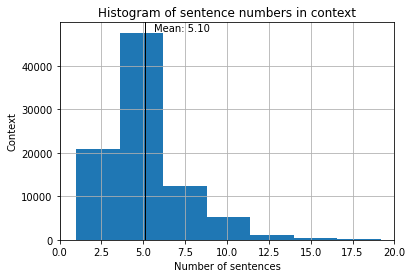

In [0]:
import matplotlib.pyplot as plt
plt.hist(train_data['Sentence_no'])
plt.xlabel('Number of sentences')
plt.ylabel('Context')
plt.title('Histogram of sentence numbers in context')
plt.xlim(0, 20)
# plt.axvline(statistics.mode(train_data['Sentence_no']), color='k', linestyle='dashed', linewidth=1)

# plt.axvline(np.median(train_data['Sentence_no']), color='k', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(train_data['Sentence_no']), color='k', linestyle='solid', linewidth=1)
min_ylim, max_ylim = plt.ylim()
# plt.text(statistics.mode(train_data['Sentence_no'])*1.1, max_ylim*0.96, 'Mode: {:.2f}'.format(statistics.mode(train_data['Sentence_no'])))

# plt.text(np.median(train_data['Sentence_no'])*0.1, max_ylim*0.96, 'Median: {:.2f}'.format(np.median(train_data['Sentence_no'])))
plt.text(np.mean(train_data['Sentence_no'])*1.1, max_ylim*0.96, 'Mean: {:.2f}'.format(np.mean(train_data['Sentence_no'])))
plt.grid(True)
plt.show()

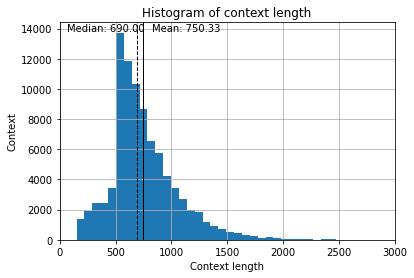

In [0]:
plt.hist(train_data['Context_length'], bins = 50)
plt.xlabel('Context length')
plt.ylabel('Context')
plt.title('Histogram of context length')
plt.xlim(0, 3000)
# plt.axvline(statistics.mode(train_data['Context_length']), color='k', linestyle='dashed', linewidth=1)

plt.axvline(np.median(train_data['Context_length']), color='k', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(train_data['Context_length']), color='k', linestyle='solid', linewidth=1)
min_ylim, max_ylim = plt.ylim()
# plt.text(statistics.mode(train_data['Context_length'])*0.1, max_ylim*0.96, 'Mode: {:.2f}'.format(statistics.mode(train_data['Context_length'])))
plt.text(np.median(train_data['Context_length'])*0.1, max_ylim*0.96, 'Median: {:.2f}'.format(np.median(train_data['Context_length'])))
plt.text(np.mean(train_data['Context_length'])*1.1, max_ylim*0.96, 'Mean: {:.2f}'.format(np.mean(train_data['Context_length'])))
plt.grid(True)
plt.show()

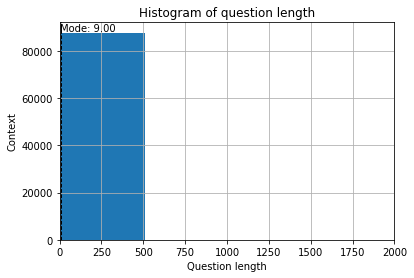

In [0]:
plt.hist(train_data['Question_length'], bins = 50)
plt.xlabel('Question length')
plt.ylabel('Context')
plt.title('Histogram of question length')
plt.xlim(0, 2000)
plt.axvline(statistics.mode(train_data['Question_length']), color='k', linestyle='dashed', linewidth=1)

# plt.axvline(np.median(train_data['Question_length']), color='k', linestyle='dashed', linewidth=1)
# plt.axvline(np.mean(train_data['Question_length']), color='k', linestyle='solid', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(statistics.mode(train_data['Question_length'])*0.1, max_ylim*0.96, 'Mode: {:.2f}'.format(statistics.mode(train_data['Question_length'])))
# plt.text(np.median(train_data['Question_length'])*0.1, max_ylim*0.96, 'Median: {:.2f}'.format(np.median(train_data['Question_length'])))
# plt.text(np.mean(train_data['Question_length'])*45.1, max_ylim*0.96, 'Mean: {:.2f}'.format(np.mean(train_data['Question_length'])))
plt.grid(True)
plt.show()

In [0]:
# train_data['Question_length'].head(100)
np.max(train_data['Question_length'])

25601

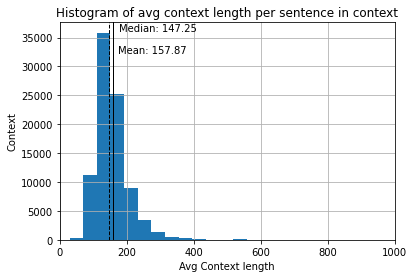

In [0]:
plt.hist(train_data['Avg_context_per_sentence'], bins = 50)
plt.xlabel('Avg Context length')
plt.ylabel('Context')
plt.title('Histogram of avg context length per sentence in context')
plt.xlim(0, 1000)

plt.axvline(np.median(train_data['Avg_context_per_sentence']), color='k', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(train_data['Avg_context_per_sentence']), color='k', linestyle='solid', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(np.median(train_data['Avg_context_per_sentence'])*1.2, max_ylim*0.96, 'Median: {:.2f}'.format(np.median(train_data['Avg_context_per_sentence'])))
plt.text(np.mean(train_data['Avg_context_per_sentence'])*1.1, max_ylim*0.86, 'Mean: {:.2f}'.format(np.mean(train_data['Avg_context_per_sentence'])))
plt.grid(True)
plt.show()

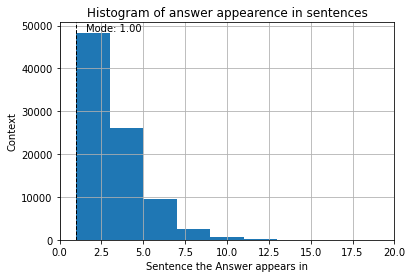

In [0]:
plt.hist(train_data['Answer_no'])
plt.xlabel('Sentence the Answer appears in')
plt.ylabel('Context')
plt.title('Histogram of answer appearence in sentences')
plt.xlim(0, 20)
plt.axvline(statistics.mode(train_data['Answer_no']), color='k', linestyle='dashed', linewidth=1)

# plt.axvline(np.median(train_data['Answer_no']), color='k', linestyle='dashed', linewidth=1)
# plt.axvline(np.mean(train_data['Answer_no']), color='k', linestyle='solid', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(statistics.mode(train_data['Answer_no'])*1.6, max_ylim*0.96, 'Mode: {:.2f}'.format(statistics.mode(train_data['Answer_no'])))
# plt.text(np.median(train_data['Answer_no'])*1.6, max_ylim*0.96, 'Median: {:.2f}'.format(np.median(train_data['Answer_no'])))
# plt.text(np.mean(train_data['Answer_no'])*1.2, max_ylim*0.86, 'Mean: {:.2f}'.format(np.mean(train_data['Answer_no'])))
plt.grid(True)
plt.show()

### Baseline Model:

In [0]:
bm_train = len(train_data[train_data['Answer_no'] ==1])/len(train_data) * 100
round(bm_train, 2)

31.89

## Pre-process Model 1 dev data


In [0]:
data=''
mypath='/gdrive/My Drive/w266/SQuad/data/dev-v1.1.json'

In [0]:
with open(mypath) as f:
    Squad = json.load(f)

In [0]:
data=get_pd_data(mypath)

In [0]:
test=data.copy()

In [0]:
test=test.apply(prepare_mod1_tar,axis=1)

In [0]:
test.to_pickle('/gdrive/My Drive/w266/SQuad/graphs_n_bm/dev_v1_pd.pkl')

In [0]:
dev_data=pd.read_pickle('/gdrive/My Drive/w266/SQuad/graphs_n_bm/dev_v1_pd.pkl')

In [0]:
dev_data['Sentence_no']=dev_data['Context'].apply(get_sen_num) 

dev_data['Answer_no']=dev_data['Target'].apply(get_answer_no)

dev_data['Context_length']=dev_data['Context'].apply(get_word_count)

dev_data['Avg_context_per_sentence']=dev_data['Context_length']/dev_data['Sentence_no']

# Baseline dev data

In [0]:
bm_dev = len(dev_data[dev_data['Answer_no'] ==1])/len(dev_data) * 100
round(bm_dev, 2)

31.98